In [1]:
import os

import pandas as pd
import numpy as np
import pickle

#%pylab widget
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import lines


import sklearn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import sklearn.linear_model

import sys
sys.path.append('../../code/scripts')
sys.path.append('../scripts')
import process_goodreads_data as gm

import train_fxns_nonimage as t
from dataset_chunking_fxns import subsample_df_by_groups
import plotting

import time
import fit_scaling_law

from importlib import reload
import pilot_sample_experiment_nonimage as p

import time
import scipy.sparse
from dataset_params import dataset_params

import matplotlib.ticker as ticker



In [2]:
def get_baseline_values_pilot(n_new,
                              num_seeds=10,
                              key_to_minimize = 'mae_max'):

    results_dir = '../../results/pilot_results/goodreads_pilot_ERM_additional_logistic_regression_2500_bruteforce_baseline'

    dfs = []
    for seed in range(num_seeds):
        csv_in_dir = os.path.join(results_dir,'baseline_additional_{1}_seed_{0}.csv'.format(seed,n_new))

        df_this = pd.read_csv(csv_in_dir)
        dfs.append(df_this)
    

    alphas = df_this['alpha'].values
    
    mae_0 = np.mean(np.array([df_this['mae_group_0'].values for df_this in dfs]),axis=0)
    mae_1= np.mean(np.array([df_this['mae_group_1'].values for df_this in dfs]),axis=0)
    mae_max = np.mean(np.array([df_this['mae_max'].values for df_this in dfs]),axis=0)
    mae_avg = np.mean(np.array([df_this['mae_avg'].values for df_this in dfs]),axis=0)
    
    if key_to_minimize == 'mae_max':
        idx_star = mae_max.argmin()
    elif key_to_minimize == 'mae_avg':
        idx_star = mae_avg.argmin()
        
    return {'alpha_star': alphas[idx_star],
           'mae_max_star': mae_max[idx_star],
           'mae_avg_star': mae_avg[idx_star],
            'mae_avg': mae_avg,
            'mae_max': mae_max,
            'mae_0': mae_0,
            'mae_1': mae_1,
           'alphas': alphas}, dfs


0.01


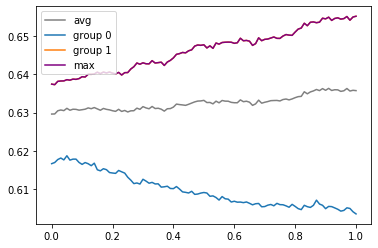

In [3]:
n_new = 5000
res, df_baseline = get_baseline_values_pilot(n_new, key_to_minimize='mae_max')
alphas = res['alphas']
mae_avg = res['mae_avg']
mae_max = res['mae_max']
mae_0 = res['mae_0']
mae_1 = res['mae_1']


plt.plot(alphas, mae_avg,'grey', label='avg')
plt.plot(alphas, mae_0, label='group 0')
plt.plot(alphas, mae_1, label='group 1')
plt.plot(alphas, mae_max, color='purple', label='max')

#plt.title(r'n_new = {0}'.format(n_new))
plt.legend()
print(res['alpha_star'])

In [4]:
reload(plotting)
plotting.setup_fonts(use_tex=True)

In [5]:
dataset_name = 'goodreads'
data_dir = '../../data'
if dataset_name.lower() == 'goodreads':
    label_colname = 'rating'
    all_group_colnames = ['history', 'fantasy']
        
    data_dir_goodreads = os.path.join(data_dir, 'goodreads')
    data_fn = os.path.join(data_dir_goodreads,
                           'goodreads_{0}_{1}_5_fold_splits.csv'.format(all_group_colnames[0],
                                                                           all_group_colnames[1]))
        
    features_fn =  data_fn.replace('5_fold_splits.csv', 'features_2k.npz')
        
    group_key = 'genre'
    group_keys_to_stratify_cv = [group_key]
        
    data = pd.read_csv(data_fn)
    X_this = scipy.sparse.load_npz(features_fn)
    
    group_id_dict = {0:'history',1:'fantasy'}
    
    gamma0 = dataset_params['goodreads']['gamma']
    gammas = [gamma0,1-gamma0]
    groups = [0,1]
    
    acc_fxns = {'mse': sklearn.metrics.mean_squared_error,
                    'mae': sklearn.metrics.mean_absolute_error}
    pred_fxn_name = 'logistic_regression'
    pred_fxn = t.fit_logistic_regression_multiclass
    model_kwargs = {'penalty': 'l2','C':1.0, 'solver':'lbfgs'}
    
    acc_key = 'mae'

In [6]:
def compile_alpha_results(rs_by_seed, alpha_keys_print, acc_key, n):
    
    num_seeds = len(rs_by_seed)
    group_results_by_alphas = np.zeros((len(alpha_keys_print), 2, num_seeds))
    for s in range(num_seeds):
        r = rs_by_seed[s]
        for k, key in enumerate(alpha_keys_print):
            results_this_alpha = r['eval_results_by_alpha'][n][key]['accs_by_group'][acc_key][:,0,:]
            group_results_by_alphas[k,:,s] = results_this_alpha.ravel()

        
    
    df = pd.DataFrame(columns=['seed','alpha_type','group_0_acc','group_1_acc', 
                           'max_over_groups','gamma_weighted_avg'])
    for k, key in enumerate(alpha_keys_print):
        for s in range(num_seeds):
            group_0_acc = group_results_by_alphas[k,0,s]
            group_1_acc = group_results_by_alphas[k,1,s]
            this_instance_dict = {'seed':s, 'alpha_type': key, 
                                  'group_0_acc': group_0_acc,
                                  'group_1_acc': group_1_acc,
                                  'max_over_groups': np.max([group_0_acc, group_1_acc]),
                                  'gamma_weighted_avg': group_0_acc*gammas[0] + group_1_acc*gammas[1]
                                 }
            df = df.append(this_instance_dict, ignore_index=True)
    return df

def read_pilot_results(results_fn,num_seeds=10, seed_start = 10):
    rs = []
    for s in range(seed_start,seed_start+num_seeds):
        fn_this = results_fn.format(s)
        with open(fn_this, 'rb') as f:
            r = pickle.load(f)
        rs.append(r)

    n_news = list(rs[0]['n_news'])
    print(n_news)

    df_all = pd.DataFrame()
    for n in n_news:
        df_this_n = compile_alpha_results(rs, alpha_keys_print, acc_key=acc_key,n=n)
        df_this_n['n_new'] = n
        df_all = pd.concat((df_all, df_this_n), ignore_index=True)
        
    return df_all, rs


def plot_pilot_sample_results(df_all,
                              alpha_type_keys,
                              nnew_key,
                              c1 = sns.color_palette('colorblind')[4],
                              c2 = sns.color_palette('colorblind')[7],
                              errtype='stddev'):
    # number of trials per run
    n_trials = len(df_all_plot['seed'].unique())            
    n_methods = df_all_plot['alphatype_numeric'].max() + 1
    
    g = sns.FacetGrid(df_all, col=nnew_key, #hue='acc_type', 
                      height=6, aspect=0.9,
                      palette=['purple','grey'], sharey='none')
    
    
    n_news = np.sort(np.unique(df_all[nnew_key]))
    for i,ax in enumerate(g.axes[0]):
        df_this_n = df_all[df_all[nnew_key] == n_news[i]]
        min_this = df_this_n[['gammaweightedavg','maxovergroups']].values.min() - 0.001
        max_this = df_this_n[['gammaweightedavg','maxovergroups']].values.max() + .0001
        
        if errtype == 'stddev':
            ci_kw = 'sd'
            plus_sds = df_this_n.groupby('alphatype').mean() + df_this_n.groupby('alphatype').std()
            minus_sds = df_this_n.groupby('alphatype').mean() - df_this_n.groupby('alphatype').std()
        elif errtype == 'stderr':
            # for standard error have to do errorbars separately
            ci_kw = None
            
            means = df_this_n.groupby('alphatype_numeric').mean()

            index_list = list(means.index)
            plot_order = []
            
            plot_order = index_list
            print(plot_order)
            
            stderrs =  df_this_n.groupby('alphatype_numeric').sem()
            plus_sds = means + stderrs
            minus_sds = means - stderrs
            
            color_dict = { 'maxovergroups': c1, 'gammaweightedavg': c2}
            label_dict = {'maxovergroups':'maximum group loss',
                          'gammaweightedavg': 'population loss'}
            marker_dict = { 'maxovergroups': 'o', 'gammaweightedavg': 'D'}
            for l in ['maxovergroups','gammaweightedavg']:
                ax.errorbar(x = plot_order, y = means[l], yerr = stderrs[l],
                            marker = marker_dict[l],
                            linewidth = 0, 
                            color = color_dict[l],
                           # ecolor='black',
                            elinewidth = 6,
                            solid_capstyle='butt',
                            markersize= 16,
                            capthick=6,
                            capsize = 16)
                
                ax.scatter([],[],  marker = marker_dict[l],
                            linewidth = 0, 
                            color = color_dict[l],
                            s= 16**2,
                            label = label_dict[l])
        else: 
            print('errtype {0} not understood'.format(errtype))
            return
            
        max_this = plus_sds[['maxovergroups','gammaweightedavg']].values.max() + 0.001
        min_this = minus_sds[['maxovergroups','gammaweightedavg']].values.min() - 0.001
        ax.set_ylim(min_this, max_this)

        ax.yaxis.set_major_locator(ticker.MultipleLocator(.01))

        if i == 0:
            ax.set_ylabel(acc_key)

        ax.set_xlabel('allocation strategy')
        ax.set_xticks(np.arange(n_methods))
        ax.set_xticklabels(alpha_type_keys,fontsize=28)
        ax.set_xlim(-0.2, n_methods - 0.8)
    leg = plt.legend(fontsize=20)
    
    return g, leg

In [7]:
n_pilot = 2500
pred_fxn_name = 'logistic_regression'
acc_key = 'mae'
param_string = 'penalty_l2_C_1.0_solver_lbfgs'

min_pts_fit = 250
results_fn = '../../results/pilot_results/goodreads_pilot_ERM_additional_{0}_{1}'.format(pred_fxn_name, n_pilot) + \
                    '/subset_genre/{0}/{1}_pilot_eval_results'.format(pred_fxn_name, param_string) + '_seed_{0}' + \
                   '_min_pts_{0}.pkl'.format(min_pts_fit)

alpha_keys_print = ['alpha_hat', 'gamma','equal_alpha']


df_all, rs_all = read_pilot_results(results_fn, num_seeds = 10, seed_start=0)

[5000, 10000, 20000, 40000]


In [8]:
# compile without baseline
n_new_key = r'$n_{\textrm{new}}$'
n_news = list(rs_all[0]['n_news'])

df_all_plot = df_all.rename(columns={'alpha_type': 'alphatype',
                       'group_0_acc': 'group0acc',
                       'group_1_acc': 'group1acc',
                       'gamma_weighted_avg': 'gammaweightedavg',
                                     'max_over_groups': 'maxovergroups',
                       'n_new': n_new_key})


# add baseline
for n_new in [5000,10000,20000,40000]:
    res, df_baselines = get_baseline_values_pilot(n_new)
    print('alpha star for ', n_new, ' is : ', res['alpha_star'])

    df_baseline_concat = pd.concat(df_baselines)
    df_baseline_concat = df_baseline_concat[df_baseline_concat['alpha'] == res['alpha_star']]
    df_baseline_concat[n_new_key] = n_new
    df_baseline_concat['alphatype'] = 'alpha_star_grid'
    df_baseline_concat = df_baseline_concat.rename(columns={'mae_group_0': 'group0acc', 
                                       'mae_group_1': 'group1acc', 
                                       'mae_max': 'maxovergroups',
                                        'mae_avg': 'gammaweightedavg'})
    df_baseline_concat = df_baseline_concat.drop(columns=['Unnamed: 0', 'alpha'])
    df_all_plot = pd.concat([df_all_plot, df_baseline_concat], sort=False)
    
# add labels and plotting order
alpha_type_keys = [ r'$\alpha^*_\textrm{grid}$',
                   r'$\widehat{\alpha}^*$',
                    r'$\gamma$',
                    r'$({1}/{2}, {1}/{2})$']

df_all_plot['alphatype_numeric'] = df_all_plot['alphatype'].replace({'alpha_star_grid':0,
                                                                    'alpha_hat':1,
                                                               'gamma': 2,
                                                               'equal_alpha': 3})

df_all_plot['alphatype'] = df_all_plot['alphatype'].replace({'alpha_star_grid':alpha_type_keys[0],
                                                             'alpha_hat':alpha_type_keys[1],
                                                               'gamma': alpha_type_keys[2],
                                                               'equal_alpha': alpha_type_keys[3]})

alpha star for  5000  is :  0.01
alpha star for  10000  is :  0.06
alpha star for  20000  is :  0.03
alpha star for  40000  is :  0.07


In [9]:
df_all_plot

,seed,alphatype,group0acc,group1acc,maxovergroups,gammaweightedavg,$n_{\textrm{new}}$,alphatype_numeric
0,0,$\widehat{\alpha}^*$,0.62064,0.63808,0.63808,0.631517,5000,1
1,1,$\widehat{\alpha}^*$,0.61072,0.63856,0.63856,0.628084,5000,1
2,2,$\widehat{\alpha}^*$,0.62648,0.64008,0.64008,0.634962,5000,1
3,3,$\widehat{\alpha}^*$,0.62128,0.63864,0.63864,0.632107,5000,1
4,4,$\widehat{\alpha}^*$,0.61480,0.63632,0.63632,0.628222,5000,1
...,...,...,...,...,...,...,...,...
7,5,$\alpha^*_\textrm{grid}$,0.55104,0.54784,0.55104,0.549044,40000,0
7,6,$\alpha^*_\textrm{grid}$,0.55040,0.54888,0.55040,0.549452,40000,0
7,7,$\alpha^*_\textrm{grid}$,0.55528,0.55344,0.55528,0.554132,40000,0
7,8,$\alpha^*_\textrm{grid}$,0.55016,0.54792,0.55016,0.548763,40000,0


[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]


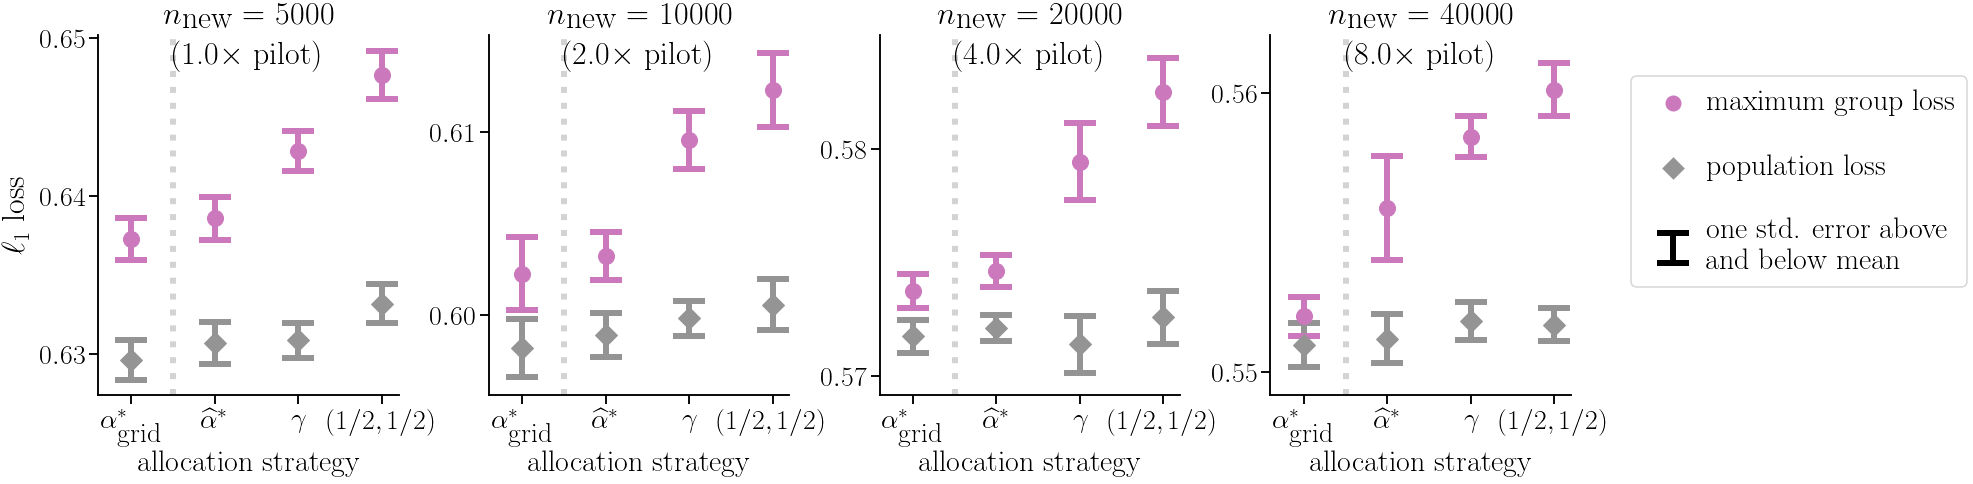

In [19]:
import matplotlib
params = {'legend.fontsize': 'large',
#           'axes.labelsize': 'large',
           'axes.titlesize':'xx-large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'}

matplotlib.rcParams.update(params)

sns.set_context('talk')
g, leg = plot_pilot_sample_results(df_all_plot,
                                   alpha_type_keys = alpha_type_keys,
                                   nnew_key = n_new_key,
                                   errtype='stderr')
axes_flat = g.axes.flatten()
for i, ax in enumerate(axes_flat):
    n_new_this = n_news[i]
    #fix title to be bigger
    ax.set_title('')
    ax.annotate(r'$n_\textrm{new}$ = '+ str(n_new_this) +'\n' + r' ({0}$\times$ pilot)'.format(n_new_this/(2*n_pilot)),
                (0.5,.92),xycoords='axes fraction', ha = 'center',
                fontsize=32)
    
    ax.axvline(0.5, color='lightgrey', linewidth=6, linestyle=':')
    
    ax.tick_params(axis='y', which='major', labelsize=28)
    ax.set_xlim(-0.4)
    
g.set_xlabels(r'allocation strategy', size=30)
g.set_ylabels(r'$\ell_1$ loss', size=32)

ax.errorbar([],[], yerr=[],  elinewidth = 6,
             solid_capstyle='butt',
             markersize= 16,
             capthick=6,
             capsize = 16,
             linestyle='', 
            color='black', label='one std. error above \n and below mean')

ax.legend()


plt.subplots_adjust(wspace=0.3)

plt.legend(ncol=1,loc=(1.2,.3), fontsize=30,handletextpad=0.1,labelspacing=1.2)

plt.savefig('../../figures/pilot_results_goodreads_tall_with_baseline_legend_right.pdf', bbox_inches='tight')

[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


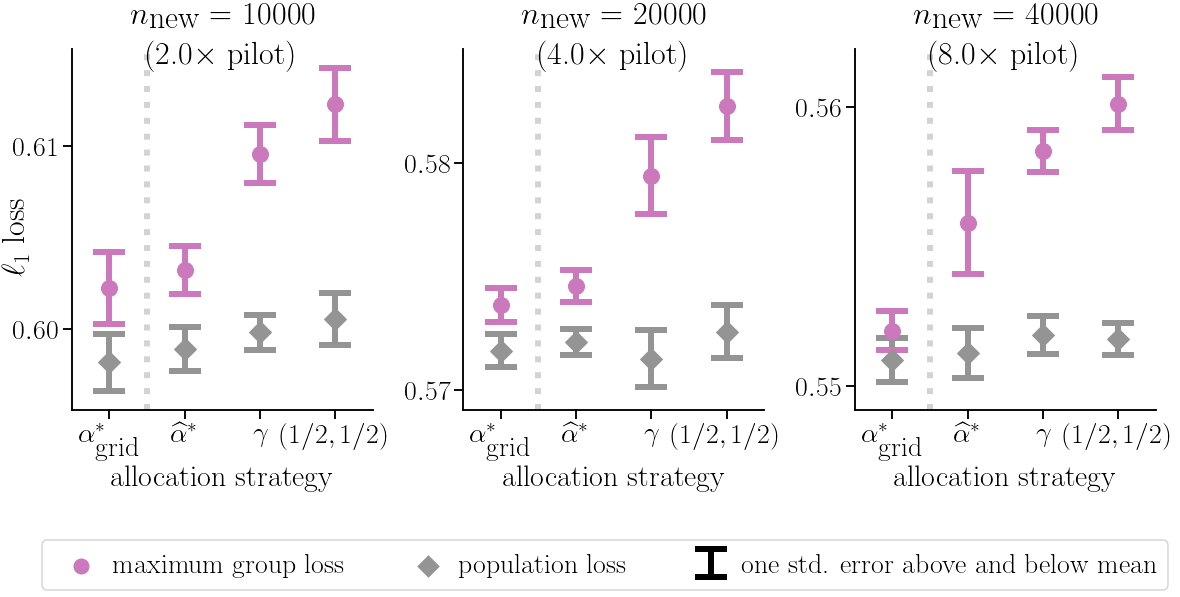

In [11]:
import matplotlib
params = {'legend.fontsize': 'large',
#           'axes.labelsize': 'large',
           'axes.titlesize':'xx-large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':28}

matplotlib.rcParams.update(params)

sns.set_context('talk')
g, leg = plot_pilot_sample_results(df_all_plot[df_all_plot[n_new_key] > 5000],
                                   alpha_type_keys = alpha_type_keys,
                                   nnew_key = n_new_key,
                                   errtype='stderr')
axes_flat = g.axes.flatten()
for i, ax in enumerate(axes_flat):
    n_new_this = n_news[i+1]
    #fix title to be bigger
    ax.set_title('')
    ax.annotate(r'$n_\textrm{new}$ = '+ str(n_new_this) +'\n' + r' ({0}$\times$ pilot)'.format(n_new_this/(2*n_pilot)),
                (0.5,.96),xycoords='axes fraction', ha = 'center',
                fontsize=32)
    
    ax.axvline(0.5, color='lightgrey', linewidth=6, linestyle=':')
    
    ax.tick_params(axis='y', which='major', labelsize=28)
    

ax.set_xlim(-0.5,3.5)
    
g.set_xlabels(r'allocation strategy', size=30)
g.set_ylabels(r'$\ell_1$ loss', size=32)
axes_flat[0].yaxis.set_label_coords(-0.12,.48)

ax.errorbar([],[], yerr=[], 
             elinewidth = 6,
             solid_capstyle='butt',
             markersize= 16,
             capthick=6,
             capsize = 16,
             linestyle='', 
             color='black', label='one std. error above and below mean')

ax.legend()


plt.subplots_adjust(wspace=0.3)

plt.legend(ncol=3,loc=(-2.7,-.5), fontsize=28,handletextpad=0.1)
plt.savefig('../../figures/pilot_results_goodreads_tall_with_baseline_only_bigger_than_pilot.pdf', bbox_inches='tight')